In [50]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [41]:
TDP = 250 # w
time = 1.6679636111111111 # hours
GPU_utilisation =  98.41828958509737 #percentage

In [42]:
dictionary = {'method':[],'energy':[]}

In [43]:
#mlco2 energy used = 0.4169909027777778 kWh
mlco2= (time * TDP) / 1000
dictionary['method'].append('time * TDP')
dictionary['energy'].append(mlco2)

In [44]:
ai_and_compute = (time * TDP * 1/3) / 1000
dictionary['method'].append('time * TDP * 1/3 util')
dictionary['energy'].append(ai_and_compute)

In [45]:
actual_util = (time * TDP * GPU_utilisation/100) / 1000
dictionary['method'].append('time * TDP * real_util')
dictionary['energy'].append(actual_util)

In [46]:
# empirical values
# nvidia-smi GPU power = 0.43921391388888886 kWh
# power monitor reading = 0.6127022608333333 kWh
power_monitor_reading = 0.6127022608333333
dictionary['method'].append('empirical')
dictionary['energy'].append(power_monitor_reading)

In [47]:
df= pd.DataFrame(dictionary)

In [48]:
df.head()

,method,energy
0,time * TDP,0.416991
1,time * TDP * 1/3 util,0.138997
2,time * TDP * real_util,0.410395
3,empirical,0.612702


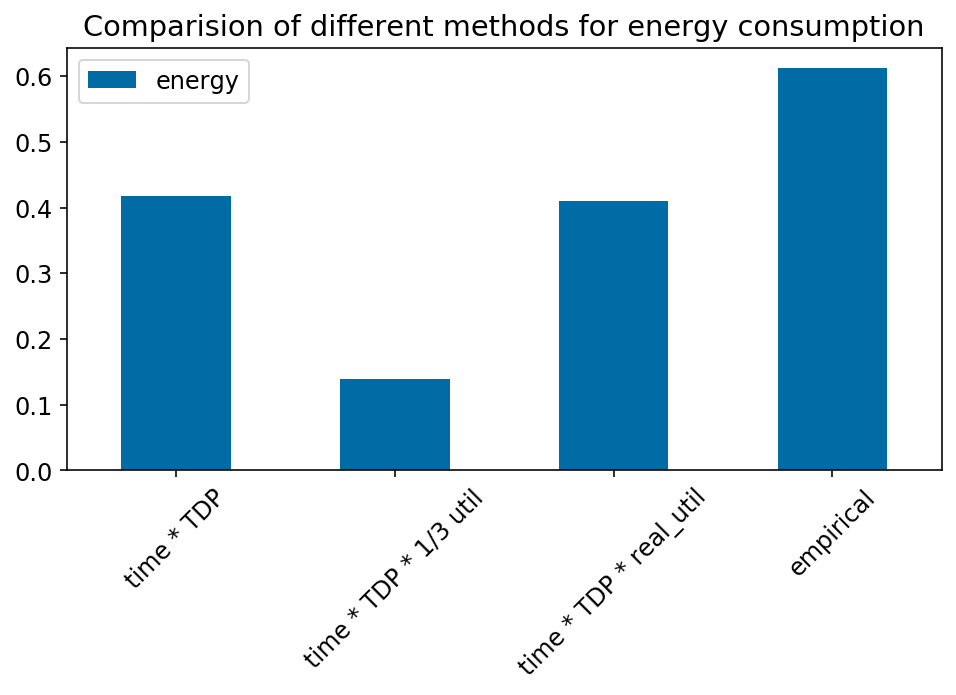

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
df.plot.bar(x='method', y='energy', rot=45,title="Comparision of different methods for energy consumption",ax=ax)
ax.set_xlabel("")
plt.tight_layout()
ax.figure.savefig("viz/compareEnergy.png",dpi=300)